<a href="https://colab.research.google.com/github/ekourkchi/incNET/blob/master/CNN_inc_CGG6_regr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
data = np.load('/content/drive/My Drive/data_56x56.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

51


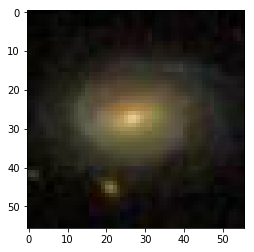

In [138]:
i = 53
print labels_[1][i]
plt.imshow(images_[i])

(array([1144., 3220., 3148., 2744., 2968., 5188., 4804., 6784., 4940.,
        9228.]),
 array([46. , 50.4, 54.8, 59.2, 63.6, 68. , 72.4, 76.8, 81.2, 85.6, 90. ]),
 <a list of 10 Patch objects>)

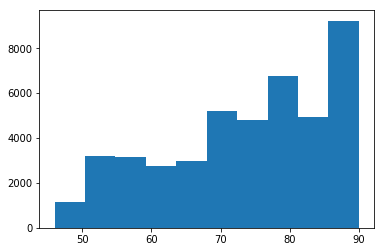

In [139]:
plt.hist(labels_[1][labels_[1]>45])

(60468, 56, 56, 3)
(44168, 56, 56, 3)
60


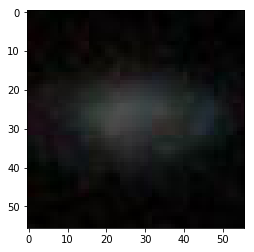

In [140]:
print images_.shape
ix, = np.where(labels_[1]>45)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

print images_c.shape

i = 100
plt.imshow(images_c[i])
print labels_c[i]


In [0]:
def esn_shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

In [0]:
n = len(labels_c)

indices = np.arange(n)
indices = esn_shuffle(indices, seed=1)


images_cc = images_c[indices]
labels_cc = labels_c[indices]
pgcIDs_cc = pgcIDs_c[indices]

#################

indices = np.arange(2000)
images_test  = images_cc[indices]
lables_test  = labels_cc[indices]
pgcIDs_test  = pgcIDs_cc[indices]

################# 

indices = np.arange(2000, n)
images_train = images_cc[indices]
lables_train = labels_cc[indices]
pgcIDs_train = pgcIDs_cc[indices]


ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
images_train = images_train[ibx]
lables_train = lables_train[ibx]
pgcIDs_train = pgcIDs_train[ibx]

#################
# Taking only unique galxies in the test set
# This is the brute-force approach.
# I need to make this better in the future

unique_IDs = []
unique_inx = []

for i, id in enumerate(pgcIDs_test):
    if not id in unique_IDs:
        unique_IDs.append(id)
        unique_inx.append(i)
        
        
images_test  = images_test[unique_inx]
lables_test  = lables_test[unique_inx]
pgcIDs_test  = pgcIDs_test[unique_inx]

images_cvl  = images_test[:1000]
lables_cvl  = lables_test[:1000]
pgcIDs_cvl  = pgcIDs_test[:1000]

images_test  = images_test[1000:]
lables_test  = lables_test[1000:]
pgcIDs_test  = pgcIDs_test[1000:]



In [143]:
print images_train.shape , lables_train.shape
print images_cvl.shape , lables_cvl.shape
print images_test.shape , lables_test.shape


(36704, 56, 56, 3) (36704,)
(1000, 56, 56, 3) (1000,)
(866, 56, 56, 3) (866,)


(array([ 23.,  65.,  57.,  65.,  63., 108.,  80., 121., 103., 181.]),
 array([46. , 50.4, 54.8, 59.2, 63.6, 68. , 72.4, 76.8, 81.2, 85.6, 90. ]),
 <a list of 1 Patch objects>)

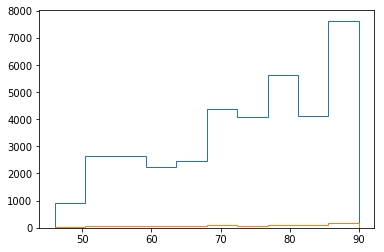

In [144]:
plt.hist(lables_train, histtype='step', label='train')
plt.hist(lables_test, histtype='step', label='test')

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(56, 56, 3)):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 56x56 images with 3 channel -> (56, 56, 3) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # model.add(tf.keras.layers.Dense(56, activation='relu', name='fc_3'))
    # model.add(tf.keras.layers.Dropout(0.10))
    
    # output layer
    model.add(tf.keras.layers.Dense(1, name='fc_out'))

    return model

In [146]:
vgg_model = vgg6()
vgg_model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
n_epochs=50
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train, lables_train, 
                                  epochs=n_epochs, batch_size=512, 
                                  validation_data=(images_cvl, lables_cvl),
                                  verbose=2, shuffle=True)


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 54, 54, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 52, 52, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 26, 26, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 22, 22, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 22, 22, 32)        128    

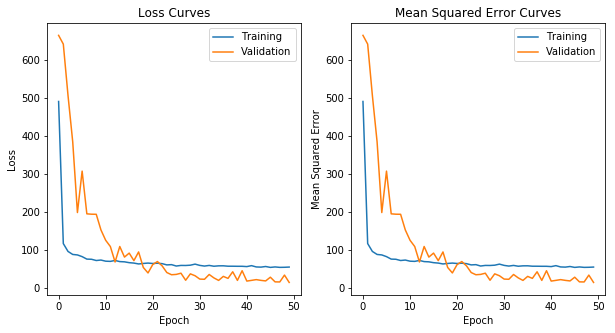

In [147]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mean_squared_error']
    val_acc = history.history['val_mean_squared_error']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Squared Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error')
    
# plot the training history
# for key in vgg_model.history.history:
#   print key

plot_model_history(vgg_model.history)
  

In [148]:
vgg_model.save("/content/drive/My Drive/CNN_inc_VGG6_regr.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
inc_p = vgg_model.predict(images_test)
inc_m = lables_test


N = images_test.shape[0]
inc_p = inc_p.reshape(N)

In [150]:
images_test.shape

(866, 56, 56, 3)

86.97281
90


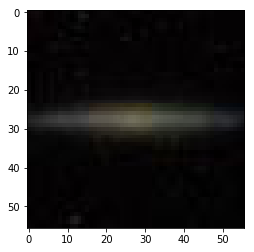

In [151]:
i = 83
print inc_p[i]
print inc_m[i]
plt.imshow(images_test[i])

3.9851622346518454 2.5520192822462966
4.0152125829106025 2.5502799961363194


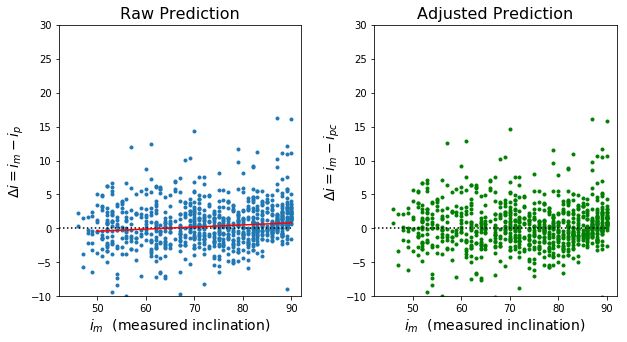

In [152]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

ix, = np.where(np.abs(d)<5)
m, b = np.polyfit(inc_m[ix], d[ix], 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, '.')
ax[0].plot([42,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(42,92)
ax[0].set_ylim(-10,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2)), np.mean(np.abs(d))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([42,90],[0,0], 'k:')
ax[1].set_xlim(42,92)
ax[1].set_ylim(-10,30)

print np.sqrt(np.mean((d_)**2)), np.mean(np.abs(d_))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

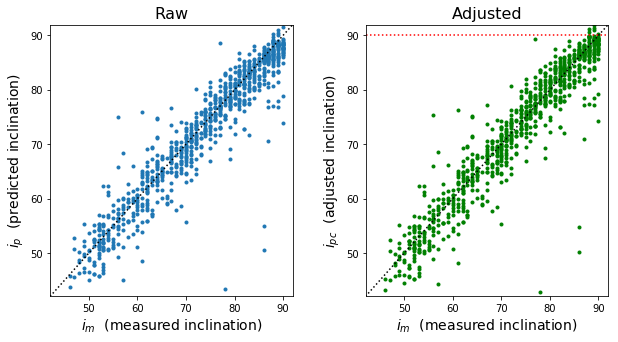

In [153]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, '.')
ax[0].plot([42,92],[42,92], 'k:')
ax[0].set_xlim(42,92)
ax[0].set_ylim(42,92)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([42,92],[42,92], 'k:')
ax[1].set_xlim(42,92)
ax[1].set_ylim(42,92)
ax[1].plot([42,92],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)

In [0]:
inc_p = vgg_model.predict(images_cvl)
inc_m = lables_cvl

N = images_cvl.shape[0]
inc_p = inc_p.reshape(N)



3.7182020950126065 2.4767607650756838
3.687388385304808 2.4398184242248537


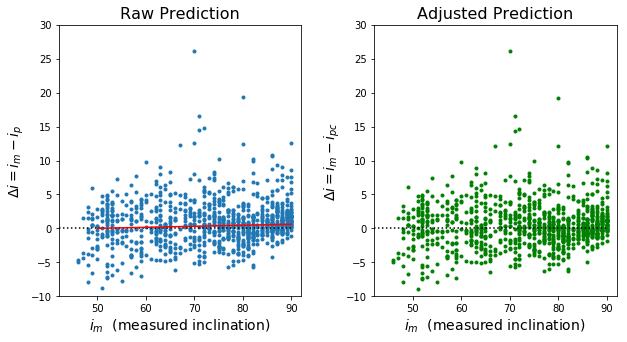

In [155]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

ix, = np.where(np.abs(d)<5)
m, b = np.polyfit(inc_m[ix], d[ix], 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, '.')
ax[0].plot([42,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(42,92)
ax[0].set_ylim(-10,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2)), np.mean(np.abs(d))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([42,90],[0,0], 'k:')
ax[1].set_xlim(42,92)
ax[1].set_ylim(-10,30)

print np.sqrt(np.mean((d_)**2)), np.mean(np.abs(d_))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

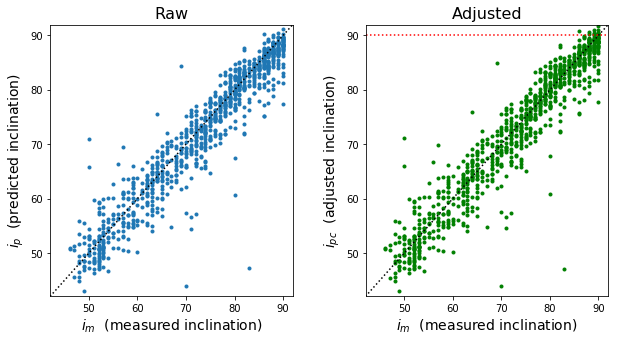

In [156]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, '.')
ax[0].plot([42,92],[42,92], 'k:')
ax[0].set_xlim(42,92)
ax[0].set_ylim(42,92)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([42,92],[42,92], 'k:')
ax[1].set_xlim(42,92)
ax[1].set_ylim(42,92)
ax[1].plot([42,92],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)

In [0]:
inc_p = vgg_model.predict(images_train)
inc_m = lables_train

N = images_train.shape[0]
inc_p = inc_p.reshape(N)

3.6233855107014543 2.459429386603697
3.6116330898631883 2.454036070662368


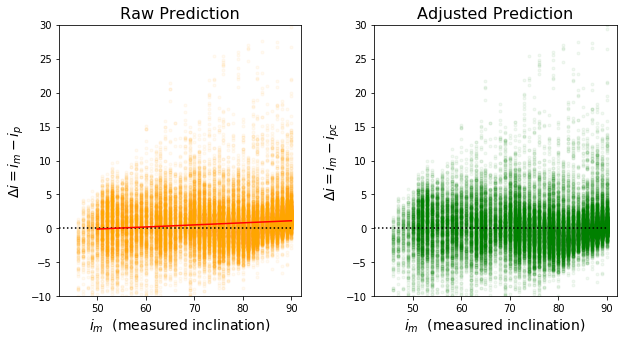

In [158]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

ix, = np.where(np.abs(d)<10)
m, b = np.polyfit(inc_m[ix], d[ix], 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, '.', color='orange', alpha=0.05)
ax[0].plot([42,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(42,92)
ax[0].set_ylim(-10,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2)), np.mean(np.abs(d))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.', alpha=0.05)
ax[1].plot([42,90],[0,0], 'k:')
ax[1].set_xlim(42,92)
ax[1].set_ylim(-10,30)

print np.sqrt(np.mean((d_)**2)), np.mean(np.abs(d_))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

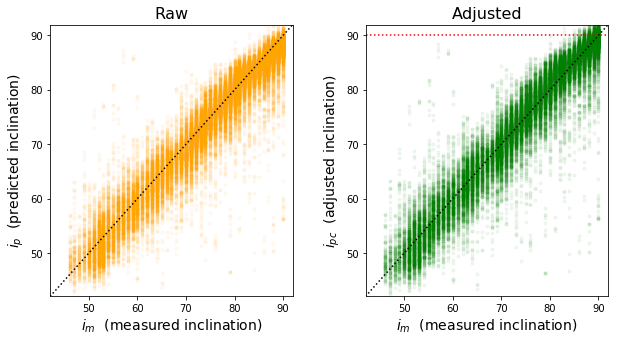

In [159]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, '.', color='orange', alpha=0.05)
ax[0].plot([42,92],[42,92], 'k:')
ax[0].set_xlim(42,92)
ax[0].set_ylim(42,92)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.', alpha=0.05)
ax[1].plot([42,92],[42,92], 'k:')
ax[1].set_xlim(42,92)
ax[1].set_ylim(42,92)
ax[1].plot([42,92],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)